# Emojify Challenge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
pip install emoji

     |████████████████████████████████| 174 kB 4.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=0b4a7479749b86200c0a1002eb16d03a72e8528532ff6137e586755fd8ec9053
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
##################################################
# Imports
##################################################

import emoji
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend
from keras.initializers import Constant

##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/content/drive/MyDrive/ML_project/data_folder'


##################################################
# Utils
##################################################

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

In [ ]:
#### Function for plotting confusion matrix ######

def plot_cf_matrix(y_true, y_pred):
  cf_matrix= confusion_matrix(y_true, y_pred);
  heatmap = sns.heatmap(cf_matrix, annot=True, cmap='YlOrRd')
  plt.xlabel("Predicted value") 
  plt.ylabel("True value") 
  return plt.show()


In [ ]:
###################################################
# Plots accuracy and loss in Train and Validation #
###################################################

def plot_accuracy_loss(history_l, K, parameters = None):
    plt.figure(figsize=(20, 7))
    colors = ["red", "blue", "orange", "green", "cyan","brown","grey"]
    #Plot accuracy
    plt.subplot(1, 2, 1)
    plt.title('Train and Validation Accuracy by Epochs')
    plt.xlabel('Epochs', fontweight='bold', fontsize=15)
    plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
    if parameters == None:
      for i in range(0, K):
          plt.plot(history_l[i].history['accuracy'], label = 'Train Accuracy Fold ' + str(i+1), color = colors[i])
          plt.plot(history_l[i].history['val_accuracy'], label = 'Validation Accuracy Fold ' + str(i+1), color = colors[i], linestyle = ":")
          plt.legend(fontsize='small')
    else:
      for i in range(0, K):
          plt.plot(history_l[i].history['accuracy'], label = 'Train Accuracy ' + str(parameters[i]), color = colors[i])
          plt.plot(history_l[i].history['val_accuracy'], label = 'Validation Accuracy ' + str(parameters[i]), color = colors[i], linestyle = ":")
          plt.legend(fontsize='medium')
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.title('Train and Validation Loss by Epochs')
    plt.xlabel('Epochs', fontweight='bold', fontsize=15)
    plt.ylabel('Loss', fontweight='bold', fontsize=15)
    if parameters == None:
      for i in range(0, K):
          plt.plot(history_l[i].history['loss'], label = 'Train Accuracy Loss Fold' + str(i+1), color = colors[i])
          plt.plot(history_l[i].history['val_loss'], label = 'Validation Accuracy Loss Fold' + str(i+1), color = colors[i], linestyle = ":")
          plt.legend(fontsize='small')
    else:
      for i in range(0, K):
          plt.plot(history_l[i].history['loss'], label = 'Train Accuracy Loss ' + str(parameters[i]), color = colors[i])
          plt.plot(history_l[i].history['val_loss'], label = 'Validation Accuracy Loss ' + str(parameters[i]), color = colors[i], linestyle = ":")
          plt.legend(fontsize='medium')
    plt.show()

# Dataset

In [ ]:

##################################################
# Load dataset
##################################################

df_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))
y_train = df_train['class']
df_validation = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))
y_validation = df_validation['class']
print(df_validation.columns)
df_test = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'test.csv'))
y_test = df_test['class']

emoji_dictionary = {
    '0': '\u2764\uFE0F',
    '1': ':baseball:',
    '2': ':smile:',
    '3': ':disappointed:',
    '4': ':fork_and_knife:'
}

# See some data examples
print('EXAMPLES:\n####################')
for idx in range(10):
  print(f'{df_train["phrase"][idx]} -> {label_to_emoji(y_train[idx])}')

print(df_train.head()) 


Index(['phrase', 'class'], dtype='object')
EXAMPLES:
####################
I want to go play -> ⚾
I want to have sushi for dinner -> 🍴
I am always working -> 😞
she is happy -> 😄
What is wrong with you -> 😞
I am proud of your achievements -> 😄
funny -> 😄
do you like pizza  -> 🍴
no one likes him -> 😞
he is the best player -> ⚾
                            phrase  class
0                I want to go play      1
1  I want to have sushi for dinner      4
2              I am always working      3
3                     she is happy      2
4           What is wrong with you      3


# Word embeddings

Words can be represented as n-dimentional vectors where the distance between points has a correspondence respect to similarity between word semantics (similar words are closer, while dissimilar ones are distant). This representation is known as word embeddings and here is extrapolated and pre-computed from the [GloVe](https://nlp.stanford.edu/projects/glove/) model. 

Here is depicted an example of bi-dimensional word embeddings:
![word embedding](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/01/word-vector-space-similar-words.jpg)

In our case a single word is represented by a vector of length 25.

# Phrase representation

All the phrases are padded to the phrase of maximum length, in this case `max_len = 10`, and each phrase is represented by the concatenation of his word embeddings (each phrase thus is a 10 * 25 = 250 dimentional vector).

In [ ]:
# Load phrase representation gloVe
x_train = np.load(
    os.path.join(DATA_BASE_FOLDER, 
                 'train.npy')).reshape(len(df_train), -1)
x_validation = np.load(
    os.path.join(DATA_BASE_FOLDER, 
                 'validation.npy')).reshape(len(df_validation), -1)

                
print(f'Word embedding size: {x_train.shape[-1]}')


Word embedding size: 250




# Visualizzazione Dati




In [ ]:
# pooled dati per GloVe
new_x_pooled = np.vstack((x_train,x_validation))
new_y_pooled = np.hstack((y_train, y_validation))

# pooled string data
df_new_train = np.vstack((df_train,df_validation))         
df_string_train = ["".join(x[0]) for x in df_new_train]
df_string_test = ["".join(x[0]) for x in pd.DataFrame.to_numpy(df_test)]


56


['i', 'want', 'to', 'go', 'play', 'i', 'want', 'to', 'have', 'sushi', 'for', 'dinner', 'i', 'am', 'always', 'working', 'she', 'is', 'happy', 'what', 'is', 'wrong', 'with', 'you', 'i', 'am', 'proud', 'of', 'your', 'achievements', 'funny', 'do', 'you', 'like', 'pizza', 'no', 'one', 'likes', 'him', 'he', 'is', 'the', 'best', 'player', 'you', 'are', 'incredibly', 'intelligent', 'and', 'talented', 'this', 'specialization', 'is', 'great', 'she', 'is', 'my', 'dearest', 'love', 'i', 'said', 'yes', 'i', 'am', 'ordering', 'food', 'i', 'like', 'you', 'a', 'lot', 'this', 'guy', 'was', 'such', 'a', 'joke', 'he', 'likes', 'baseball', 'so', 'sad', 'you', 'are', 'not', 'coming', 'what', 'are', 'the', 'rules', 'of', 'the', 'game', 'too', 'bad', 'that', 'you', 'were', 'not', 'here', 'i', 'am', 'looking', 'for', 'a', 'date', 'where', 'is', 'the', 'stadium', 'this', 'is', 'so', 'funny', 'the', 'chicago', 'cubs', 'won', 'again', 'french', 'macaroon', 'is', 'so', 'tasty', 'miss', 'you', 'my', 'dear', 'food'

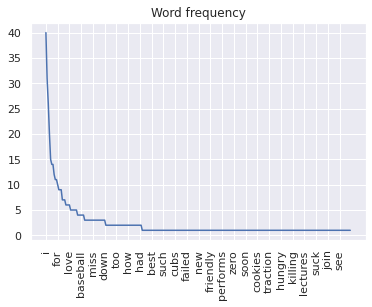

In [ ]:
# words occurrences
word_frequency = {}

new_str = ' '.join(df_string_train);
print(new_str.lower().split())
for word in new_str.lower().split():
    if word not in word_frequency:
      word_frequency[word] = 0    
    word_frequency[word] += 1

newd = dict(sorted(word_frequency.items(), key=lambda item: item[1], reverse=True))
print(len(newd))


# plot 
plt.plot(list(newd.keys()),list(newd.values()))
plt.xticks(list(newd.keys())[::10], rotation = "vertical");
plt.title("Word frequency");

Class count

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


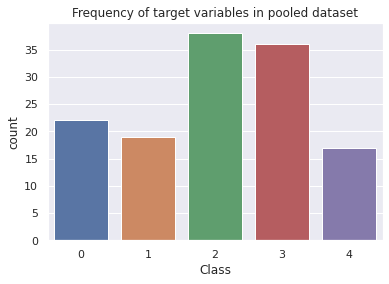

In [ ]:
sns.countplot(new_y_pooled).set_title('Frequency of target variables in pooled dataset')
plt.xlabel('Class');


#Pre-processing data









processing data for *Bag-of-Words*

Convert a collection of text documents to a matrix of token counts



In [ ]:
vect = CountVectorizer().fit(df_string_train)
standCV_comp = vect.transform(df_string_train)

Using Stopwords to reduce number of features


In [ ]:
# Using Stopwords
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopwords: \n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopwords: 
['do', 'some', 'sincere', 'why', 'whereupon', 'nevertheless', 'has', 'within', 'hereby', 'nor', 'please', 'seeming', 'other', 'onto', 'amongst', 'therefore', 'detail', 'keep', 'latterly', 'another', 'eg', 'they', 'against', 'less', 'thick', 'hers', 'ourselves', 'whenever', 'somewhere', 'himself', 'but', 'along']


In [ ]:
#the comparison between using stop_words and not
vect_sw = CountVectorizer(min_df=1, stop_words='english').fit(df_string_train)
stopw_x_train = vect_sw.transform(df_string_train)
print('X_train shape using Stop words: {}'.format(stopw_x_train.shape[1]))
print('Standard CountVectorizer shape: {}'.format(standCV_comp.shape[1]))
print('Thank to Stopwords we discard {} features (words).'.format(standCV_comp.shape[1]-stopw_x_train.shape[1]))

X_train shape using Stop words: 183
Standard CountVectorizer shape: 258
Thank to Stopwords we discard 75 features (words).


Transform data with Lemmatization



In [ ]:
#Convert each document into a list of tokens using the tokenizer parameter
#regexp used in CounterVector
regexp = re.compile('(?u)\\b\\w\\w+\\b')

en_nlp = spacy.load('en')
old_tokenizer = en_nlp.tokenizer
#replace the tokenizer with regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))
#create a custom tokenizer using the spacy document pipeline
def our_tokenizer(document):
  doc_spacy = en_nlp(document)
  return [token.lemma_ for token in doc_spacy]

#define a count vectorizer with the custom tokenizer to do Lemmatization
lemma_vect = CountVectorizer(tokenizer = our_tokenizer, min_df = 1, stop_words = 'english')
lemma_vect_tfidf = TfidfVectorizer(tokenizer = our_tokenizer, min_df = 1, stop_words= 'english')

In [ ]:
x_train_lemma = lemma_vect.fit_transform(df_string_train);
x_train_lemma_tfidf = lemma_vect_tfidf.fit_transform(df_string_train);
#standard CountVectorizer for comparison

print('Standard CountVectorizer shape: {}'.format(standCV_comp.shape))
print('X_train_lemma shape: {}'.format(x_train_lemma.shape))
print('Thank to Lemmatization we discard {} features'.format(standCV_comp.shape[1]-x_train_lemma.shape[1]))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-PRON-', 'make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-PRON-', 'make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Standard CountVectorizer shape: (132, 258)
X_train_lemma shape: (132, 166)
Thank to Lemmatization we discard 92 features


**TF-IDF** 

Instead of dropping features that are unimportant, another approach is to rescale features by how informative we expect them to be. To do this we can use term frequency-inverse document frequency (Tf-IDF). The intuition of this method is to give high weight to any term that appears often in a particular document, in this case phrase, but not in many documents in the corpus.


**Riscrivere questa parte**

For GloVe use standard preprocessing steps like stemming, lowercasing or stopword removal when you have pre-trained emb eddings
Some of you might used standard preprocessing steps when doing word count based feature extraction (e.g. TFIDF) such as removing stopwords, stemming etc. The reason is simple: You loose valuable information, which would help your NN to figure things out.

# Model

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the sklearn (or optionally other more advanced frameworks such as pytorch or tensorflow) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

## Logistic Regression


**Standard Bag-of-words**

In [ ]:
#
pipe_bof_lr = make_pipeline(CountVectorizer(min_df = 1), LogisticRegression())
#
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 5, 10, 50,100],
              'countvectorizer__ngram_range': [(1,1),(1,2)],
              'countvectorizer__stop_words':['english', None]}
grid_bof_lr = GridSearchCV(pipe_bof_lr, param_grid , cv = 5)
grid_bof_lr.fit(df_string_train, new_y_pooled)

print("Best cross-validation score: {:.4f}".format(grid_bof_lr.best_score_))
print("Best parameters:\n{}".format(grid_bof_lr.best_params_))

Best cross-validation score: 0.6501
Best parameters:
{'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 5}


In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50,100]}
grid_bof_lr = GridSearchCV(LogisticRegression(), param_grid= param_grid, cv = 5)
grid_bof_lr.fit(x_train_lemma, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_bof_lr.best_score_))
print("Best parameters:\n{}".format(grid_bof_lr.best_params_))

Best cross-validation score: 0.6661
Best parameters:
{'C': 1}


**Tf-idf**

In [ ]:
pipe_tfidf_lr = make_pipeline(TfidfVectorizer(min_df = 1), LogisticRegression())
#
param_grid = {'logisticregression__C': [0.1, 1, 5, 10, 25, 50,100],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],
              'tfidfvectorizer__stop_words':['english', None]}
grid_tfidf_lr = GridSearchCV(pipe_tfidf_lr, param_grid , cv = 5)
grid_tfidf_lr.fit(df_string_train, new_y_pooled)

print("Best cross-validation score: {:.4f}".format(grid_tfidf_lr.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_lr.best_params_))

Best cross-validation score: 0.6806
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': 'english'}


In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50,100]}
grid_tfidf_lr = GridSearchCV(LogisticRegression(), param_grid= param_grid, cv = 5)
grid_tfidf_lr.fit(x_train_lemma_tfidf, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_tfidf_lr.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_lr.best_params_))

Best cross-validation score: 0.6732
Best parameters:
{'C': 10}


**GloVe**

In [ ]:
#
param_grid = {'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1]}
#pipe_glove_lr = make_pipeline(MinMaxScaler(feature_range= (np.min(new_x_pooled),np.max(new_x_pooled))),LogisticRegression(max_iter=1000))
pipe_glove_lr = make_pipeline(LogisticRegression(max_iter=1000))
#pipe_glove_lr = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000))

grid_glove_lr = GridSearchCV(pipe_glove_lr, param_grid , cv = 5)
grid_glove_lr.fit(new_x_pooled, new_y_pooled)
print("Best cross-validation score: {:.4f}".format(grid_glove_lr.best_score_))
print("Best parameters:\n{}".format(grid_glove_lr.best_params_))



Best cross-validation score: 0.6436
Best parameters:
{'logisticregression__C': 0.1}


**Best Logistic Regression model**

Best accuracy score for Logistic Regression: 0.7059
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       1.00      0.71      0.83         7
           2       1.00      0.57      0.73         7
           3       0.43      0.86      0.57         7
           4       1.00      0.86      0.92         7

    accuracy                           0.71        34
   macro avg       0.81      0.70      0.72        34
weighted avg       0.81      0.71      0.73        34



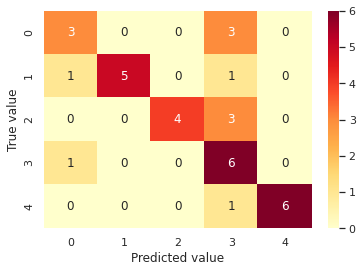

In [ ]:
vect_lr = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 1)).fit(df_string_train)
x_train_vect_lr = vect_lr.transform(df_string_train)
x_test_vect_lr =  vect_lr.transform(df_string_test)
best_lr = LogisticRegression(C = 10).fit(x_train_vect_lr, new_y_pooled)
y_pred_lr = best_lr.predict(x_test_vect_lr)
#accuracy(y_pred_lr,y_test)
print("Best accuracy score for Logistic Regression: {:.4f}".format(best_lr.score(x_test_vect_lr,y_test)))
print(classification_report(y_test, y_pred_lr ))
plot_cf_matrix(y_test, y_pred_lr)

# Using lemmatization --> ending up with the same accuracy score
# x_train_lemma_lr = lemma_vect_tfidf.fit_transform(df_string_train)
# x_test_lemma_lr = lemma_vect_tfidf.transform(df_string_test)
# best_lr = LogisticRegression(C = 10).fit(x_train_lemma_lr, new_y_pooled)
# y_pred_lr = best_lr.predict(x_test_lemma_lr)
# print("Best accuracy score for Logistic Regression: {:.4f}".format(best_lr.score(x_test_lemma_lr,y_test)))
# print(classification_report(y_test, y_pred_lr ))
# plot_cf_matrix(y_test, y_pred_lr)

## Random Forest \ Decision tree

**Standard Bag-of-words**

In [ ]:

pipe_bof_rf = make_pipeline(CountVectorizer(min_df = 1), RandomForestClassifier())

param_grid = {'randomforestclassifier__n_estimators': [500],
              'randomforestclassifier__max_features': [15,20,30],
              'countvectorizer__ngram_range': [(1,1),(1,2)],
              'countvectorizer__stop_words':['english', None]}
grid_bof_rf = GridSearchCV(pipe_bof_rf, param_grid , cv = 5)
grid_bof_rf.fit(df_string_train, new_y_pooled)

print("Best cross-validation score: {:.4f}".format(grid_bof_rf.best_score_))
print("Best parameters:\n{}".format(grid_bof_rf.best_params_))

Best cross-validation score: 0.6046
Best parameters:
{'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': 'english', 'randomforestclassifier__max_features': 15, 'randomforestclassifier__n_estimators': 500}


In [ ]:
param_grid = {'n_estimators': [500],
              'max_features': [20,25 ,30]}
grid_bof_rf = GridSearchCV(RandomForestClassifier(), param_grid= param_grid, cv = 5)
grid_bof_rf.fit(x_train_lemma, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_bof_rf.best_score_))
print("Best parameters:\n{}".format(grid_bof_rf.best_params_))

Best cross-validation score: 0.5974
Best parameters:
{'max_features': 20, 'n_estimators': 500}


**Tf-idf**

In [ ]:
pipe_tfidf_rf = make_pipeline(TfidfVectorizer(min_df = 1), RandomForestClassifier())
#
param_grid = {'randomforestclassifier__n_estimators': [500],
              'randomforestclassifier__max_features': [15,20,30],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],
              'tfidfvectorizer__stop_words':['english', None]}
grid_tfidf_rf = GridSearchCV(pipe_tfidf_rf, param_grid , cv = 5)
grid_tfidf_rf.fit(df_string_train, new_y_pooled)
print("Best cross-validation score: {:.7f}".format(grid_tfidf_rf.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_rf.best_params_))    

Best cross-validation score: 0.6267806
Best parameters:
{'randomforestclassifier__max_features': 15, 'randomforestclassifier__n_estimators': 500, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': 'english'}


In [ ]:
param_grid = {'n_estimators': [500],
              'max_features': [20,25 ,30]}
grid_tfidf_rf = GridSearchCV(RandomForestClassifier(), param_grid= param_grid, cv = 5)
grid_tfidf_rf.fit(x_train_lemma_tfidf, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_tfidf_rf.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_rf.best_params_))

Best cross-validation score: 0.6123
Best parameters:
{'max_features': 20, 'n_estimators': 500}


**GloVe**

In [ ]:
#  Decision Tree model don't need rescaling of the data
param_grid = {'randomforestclassifier__n_estimators': [500],
              'randomforestclassifier__max_features': [20,25 ,30]}
pipe_glove_rf = make_pipeline(RandomForestClassifier())
grid_glove_rf = GridSearchCV(pipe_glove_rf, param_grid , cv = 5)
grid_glove_rf.fit(new_x_pooled, new_y_pooled)
print("Best cross-validation score: {:.4f}".format(grid_glove_rf.best_score_))
print("Best parameters:\n{}".format(grid_glove_rf.best_params_))


Best cross-validation score: 0.5308
Best parameters:
{'randomforestclassifier__max_features': 20, 'randomforestclassifier__n_estimators': 500}


**Best Random Forest model**

Best accuracy score for Random Forest: 0.6176
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       1.00      0.71      0.83         7
           2       0.67      0.57      0.62         7
           3       0.38      0.86      0.52         7
           4       1.00      0.57      0.73         7

    accuracy                           0.62        34
   macro avg       0.74      0.61      0.63        34
weighted avg       0.74      0.62      0.63        34



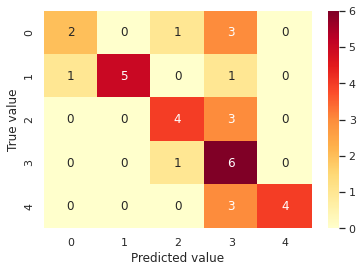

In [ ]:
vect_rf = CountVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 1)).fit(df_string_train)
x_train_vect_rf = vect_rf.transform(df_string_train)
x_test_vect_rf =  vect_rf.transform(df_string_test)
best_rf = RandomForestClassifier(n_estimators=500,max_features=15).fit(x_train_vect_rf, new_y_pooled)
y_pred_rf = best_rf.predict(x_test_vect_rf)
print("Best accuracy score for Random Forest: {:.4f}".format(best_rf.score(x_test_vect_rf,y_test)))
print(classification_report(y_test, y_pred_rf ))
plot_cf_matrix(y_test, y_pred_rf)


## K-nearest neighbors

**Standard Bag-of-words**

In [ ]:
pipe_bof_knn = make_pipeline(CountVectorizer(min_df = 1), KNeighborsClassifier())

param_grid = {'kneighborsclassifier__n_neighbors':[2,3,4,5,7,9],
              'kneighborsclassifier__metric': ['minkowski', 'euclidean'],
              'countvectorizer__ngram_range': [(1,1),(1,2)],
              'countvectorizer__stop_words':['english', None]}
grid_bof_knn = GridSearchCV(pipe_bof_knn, param_grid , cv = 5)
grid_bof_knn.fit(df_string_train, new_y_pooled)

print("Best cross-validation score: {:.4f}".format(grid_bof_knn.best_score_))
print("Best parameters:\n{}".format(grid_bof_knn.best_params_))

Best cross-validation score: 0.5977
Best parameters:
{'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 3}


In [ ]:
param_grid = {'n_neighbors':[2,3,4,5,7,9],
             'metric': ['minkowski', 'euclidean']}
grid_bof_knn = GridSearchCV(KNeighborsClassifier(), param_grid= param_grid, cv = 5)
grid_bof_knn.fit(x_train_lemma, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_bof_knn.best_score_))
print("Best parameters:\n{}".format(grid_bof_knn.best_params_))

Best cross-validation score: 0.5293
Best parameters:
{'metric': 'minkowski', 'n_neighbors': 3}


**Tf-idf**

In [ ]:
pipe_tfidf_knn = make_pipeline(TfidfVectorizer(min_df = 1), KNeighborsClassifier())
#
param_grid = {'kneighborsclassifier__n_neighbors':[2,3,4,5,7,9],
              'kneighborsclassifier__metric': ['minkowski', 'euclidean'],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],
              'tfidfvectorizer__stop_words':['english', None]}
grid_tfidf_knn = GridSearchCV(pipe_tfidf_knn, param_grid , cv = 5)
grid_tfidf_knn.fit(df_string_train, new_y_pooled)
print("Best cross-validation score: {:.7f}".format(grid_tfidf_knn.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_knn.best_params_))   

Best cross-validation score: 0.5672365
Best parameters:
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 4, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__stop_words': None}


In [ ]:
param_grid = {'n_neighbors':[2,3,4,5,7,9],
             'metric': ['minkowski', 'euclidean']}
grid_tfidf_knn = GridSearchCV(KNeighborsClassifier(), param_grid= param_grid, cv = 5)
grid_tfidf_knn.fit(x_train_lemma_tfidf, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_tfidf_knn.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_knn.best_params_))

Best cross-validation score: 0.5991
Best parameters:
{'metric': 'minkowski', 'n_neighbors': 4}


**GloVe**

In [ ]:
param_grid = {'kneighborsclassifier__n_neighbors':[2,3,4,5,7,9],
             'kneighborsclassifier__metric': ['minkowski', 'euclidean']}
pipe_glove_knn= make_pipeline(MinMaxScaler(),KNeighborsClassifier())
#pipe_glove_knn = make_pipeline(KNeighborsClassifier())
#pipe_glove_knn = make_pipeline(StandardScaler(),KNeighborsClassifier())

grid_glove_knn = GridSearchCV(pipe_glove_knn, param_grid , cv = 5)
grid_glove_knn.fit(new_x_pooled, new_y_pooled)
print("Best cross-validation score: {:.4f}".format(grid_glove_knn.best_score_))
print("Best parameters:\n{}".format(grid_glove_knn.best_params_))

Best cross-validation score: 0.5607
Best parameters:
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 5}


**Best K-NN model**

Best accuracy score for K-NN: 0.6176
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       1.00      0.71      0.83         7
           2       0.46      0.86      0.60         7
           3       0.56      0.71      0.63         7
           4       1.00      0.29      0.44         7

    accuracy                           0.62        34
   macro avg       0.72      0.61      0.61        34
weighted avg       0.73      0.62      0.61        34



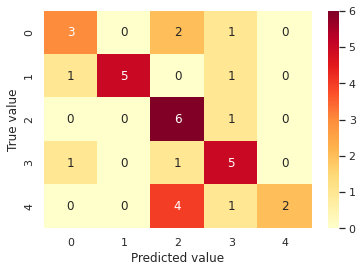

In [ ]:
vect_knn = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 1)).fit(df_string_train)
#vect_knn = lemma_vect_tfidf.fit(df_string_train)
x_train_vect_knn = vect_knn.transform(df_string_train)
x_test_vect_knn =  vect_knn.transform(df_string_test)
best_knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors =  3).fit(x_train_vect_knn, new_y_pooled)
#best_knn = KNeighborsClassifier(metric = 'minkowski', n_neighbors =  4).fit(x_train_vect_knn, new_y_pooled)

y_pred_knn = best_knn.predict(x_test_vect_knn)
print("Best accuracy score for K-NN: {:.4f}".format(best_knn.score(x_test_vect_knn,y_test)))
print(classification_report(y_test, y_pred_knn))
plot_cf_matrix(y_test, y_pred_knn)


## Support Vector Machine

**Standard Bag-of-words**

In [ ]:
pipe_bof_svm = make_pipeline(CountVectorizer(min_df = 1), SVC())

param_grid = {'svc__C':[0.1,1,10,100, 1000],
             'svc__gamma':[0.001,0.01,0.1,1,10,100],
             'svc__kernel': ['linear', 'rbf'],
              'countvectorizer__ngram_range': [(1,1),(1,2)],
              'countvectorizer__stop_words':['english', None]}
grid_bof_svm = GridSearchCV(pipe_bof_svm, param_grid , cv = 5)
grid_bof_svm.fit(df_string_train, new_y_pooled)

print("Best cross-validation score: {:.4f}".format(grid_bof_svm.best_score_))
print("Best parameters:\n{}".format(grid_bof_svm.best_params_))

Best cross-validation score: 0.6048
Best parameters:
{'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}


In [ ]:
param_grid = {'C':[0.01,0.1,1,10,100],
             'gamma':[0.001,0.01,0.1,1,10,100],
              'kernel': ['linear', 'rbf']}
grid_bof_svm = GridSearchCV(SVC(), param_grid= param_grid, cv = 5)
grid_bof_svm.fit(x_train_lemma, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_bof_svm.best_score_))
print("Best parameters:\n{}".format(grid_bof_svm.best_params_))

Best cross-validation score: 0.6655
Best parameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


**Tf-idf**

In [ ]:
pipe_tfidf_svm = make_pipeline(TfidfVectorizer(min_df = 1), SVC())
#
param_grid = {'svc__C':[1,10,25,50],
             'svc__gamma':[0.01,0.05,0.1,0.5,1],
              'svc__kernel': ['linear', 'rbf'],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],
              'tfidfvectorizer__stop_words':['english', None]}
grid_tfidf_svm = GridSearchCV(pipe_tfidf_svm, param_grid , cv = 5)
grid_tfidf_svm.fit(df_string_train, new_y_pooled)
print("Best cross-validation score: {:.4f}".format(grid_tfidf_svm.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_svm.best_params_))

Best cross-validation score: 0.6806
Best parameters:
{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__stop_words': 'english'}


In [ ]:
param_grid = {'C':[0.01,0.1,1,10,100],
             'gamma':[0.001,0.01,0.1,1,10,100],
              'kernel': ['linear', 'rbf'],}
grid_tfidf_svm = GridSearchCV(SVC(), param_grid= param_grid, cv = 5)
grid_tfidf_svm.fit(x_train_lemma_tfidf, new_y_pooled) # lemma with stopwords

print("Best cross-validation score: {:.4f}".format(grid_tfidf_svm.best_score_))
print("Best parameters:\n{}".format(grid_tfidf_svm.best_params_))

Best cross-validation score: 0.6735
Best parameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


**GloVe**

In [ ]:
param_grid = {'svc__C':[0.01,0.1,1,10,50,100],
             'svc__gamma':[0.001,0.005,0.01,0.1,1,10],
              'svc__kernel': ['linear', 'rbf']}
#pipe_glove_svm = make_pipeline(MinMaxScaler(),SVC())
#pipe_glove_svm = make_pipeline(SVC())
pipe_glove_svm = make_pipeline(StandardScaler(),SVC())

grid_glove_svm = GridSearchCV(pipe_glove_svm, param_grid , cv = 5)
grid_glove_svm.fit(new_x_pooled, new_y_pooled)
print("Best cross-validation score: {:.4f}".format(grid_glove_svm.best_score_))
print("Best parameters:\n{}".format(grid_glove_svm.best_params_))

Best cross-validation score: 0.6442
Best parameters:
{'svc__C': 0.01, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}


**Best SVM model**

Best accuracy score for Supported Vector Machinie: 0.7059
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       1.00      0.71      0.83         7
           2       1.00      0.57      0.73         7
           3       0.43      0.86      0.57         7
           4       1.00      0.86      0.92         7

    accuracy                           0.71        34
   macro avg       0.81      0.70      0.72        34
weighted avg       0.81      0.71      0.73        34



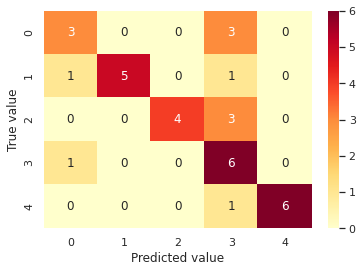

In [ ]:
vect_svm = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 2)).fit(df_string_train)
x_train_vect_svm = vect_svm.transform(df_string_train)
x_test_vect_svm =  vect_svm.transform(df_string_test)
best_svm = SVC(C = 10, gamma = 0.1, kernel = 'rbf').fit(x_train_vect_svm, new_y_pooled)
y_pred_svm = best_svm.predict(x_test_vect_svm)
# can't increase the result even if using lemmatization
print("Best accuracy score for Supported Vector Machinie: {:.4f}".format(best_svm.score(x_test_vect_svm,y_test)))
print(classification_report(y_test, y_pred_svm ))
plot_cf_matrix(y_test, y_pred_svm)

## Neural Networks

In [ ]:
# one hot-encoding for train and validation
from keras.utils.np_utils import to_categorical


categorical_y_train = to_categorical(y_train)
categorical_y_validation = to_categorical(y_validation)

# merge one hot-encoding
targets = np.concatenate((categorical_y_train, categorical_y_validation), axis = 0)

### Naive Neural Networks

Test different value of activation function

In [ ]:
parameters = ['relu', 'tanh', 'sigmoid']
evolution_activation = []
for activation in parameters:
  naive_model = Sequential()
  naive_model.add(Dense(64, activation = activation, input_dim=250))
  naive_model.add(Dropout(0.5))
  naive_model.add(Dense(5, activation='softmax'))
  naive_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = naive_model.fit(x_train, categorical_y_train, batch_size=32, epochs=75,validation_data=(x_validation, categorical_y_validation))
  evolution_activation.append(history)



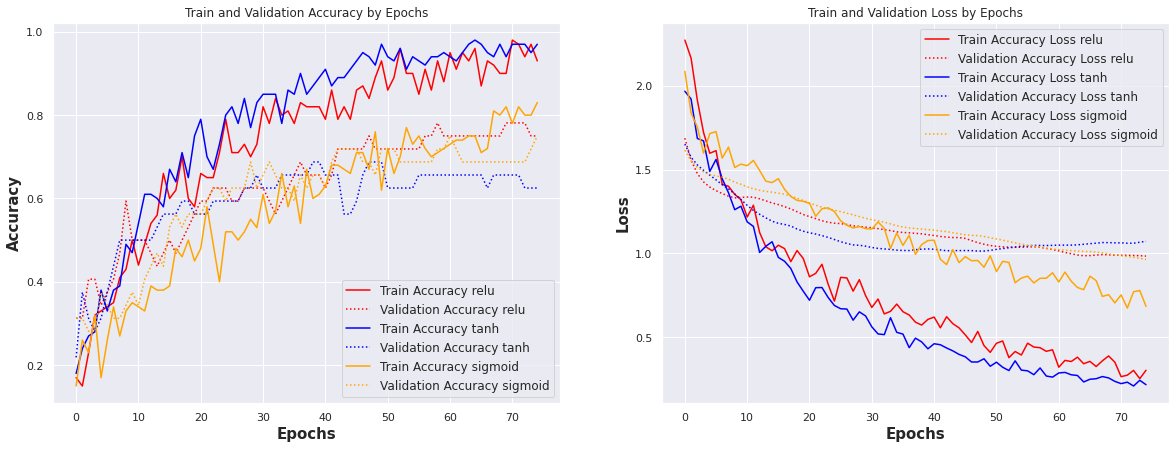

In [ ]:
plot_accuracy_loss(evolution_activation, len(parameters), parameters)

Test different value of dropout rate

In [ ]:
parameters = [0.001, 0.25, 0.35, 0.5]
evolution_dropout = []
for dropout in parameters:
  naive_model = Sequential()
  naive_model.add(Dense(64, activation = "relu", input_dim=250))
  naive_model.add(Dropout(dropout))
  naive_model.add(Dense(5, activation='softmax'))
  naive_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = naive_model.fit(x_train, categorical_y_train, batch_size=32, epochs=75,validation_data=(x_validation, categorical_y_validation))
  evolution_dropout.append(history)



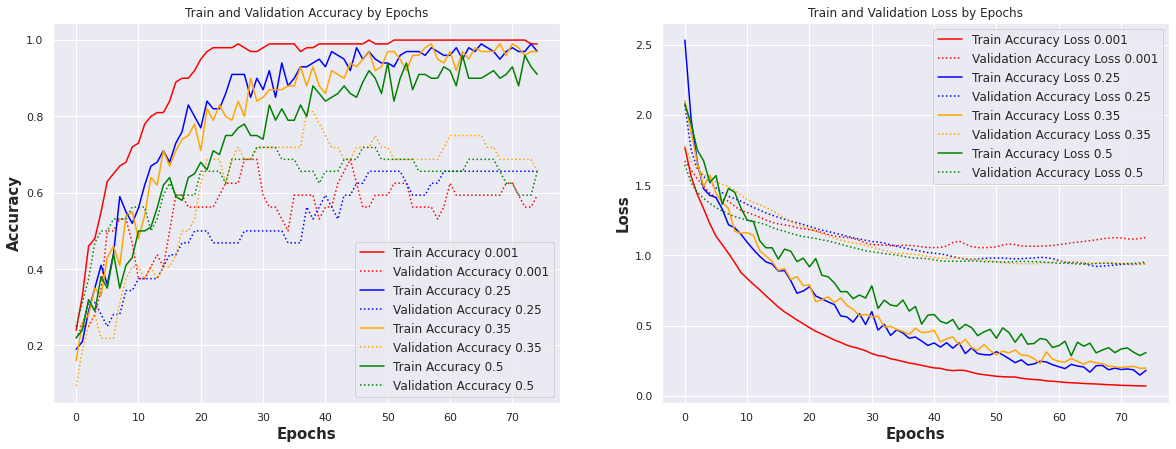

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

K-Fold cross-validation


In [ ]:

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

K = 7   # numbers of folds
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True) # creating the stratified k-fold cross validation


In [ ]:
validation_accuracy = []
validation_loss = []
k_fold_evolution = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(132),new_y_pooled):
  training_data = new_x_pooled[train_index]
  training_targets = targets[train_index]
  validation_data = new_x_pooled[val_index]
  validation_targets = targets[val_index]
  # create and compile new model
  naive_model = Sequential()
  naive_model.add(Dense(64, activation = "relu", input_dim=250))
  naive_model.add(Dropout(0.35))
  naive_model.add(Dense(5, activation='softmax'))
  naive_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

  print('------------------------------------------------------------------------')
  print('------------------------ history for fold {} ----------------------------'.format(fold_var))
  print('------------------------------------------------------------------------')
  history = naive_model.fit(training_data, training_targets, batch_size=32, epochs=75,validation_data=(validation_data, validation_targets));

  # CREATE CALLBACKS
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
	# This saves the best model
  # Generate generalization metrics	
  results = naive_model.evaluate(validation_data,validation_targets,verbose=0)
  results = dict(zip(naive_model.metrics_names,results))
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  k_fold_evolution.append(history)
	
  backend.clear_session()
  fold_var += 1 # Increase fold number

    



Average scores for all folds:
> Accuracy: 61.278195892061504% (+- 7.270330815601443%)
> Loss: 1.071645166192736




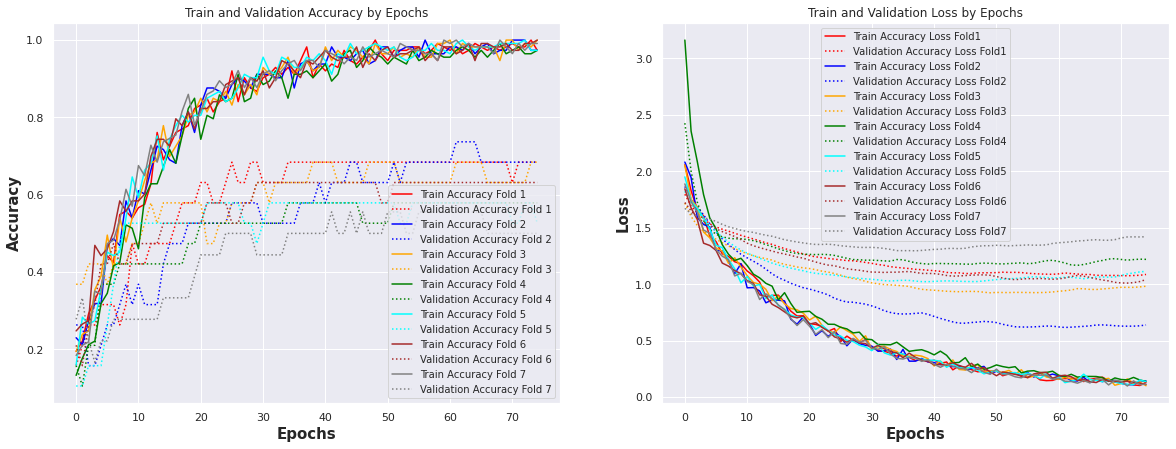

In [ ]:
# print useful result of stratified k-fold cross validation
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(validation_accuracy)*100}% (+- {np.std(validation_accuracy)*100}%)')
print(f'> Loss: {np.mean(validation_loss)}\n\n')
# plotting resuls of stratified k-fold cross validation
plot_accuracy_loss(k_fold_evolution,K)



### Deep Neural Network


Test different type of architecture

In [ ]:
first_layer_dim = [128,64]
second_layer_dim = [64,32,16]
evolution_architecture = []
for dim_1 in first_layer_dim:
  for dim_2 in second_layer_dim:
    dnn_model = Sequential()
    dnn_model.add(Dense(dim_1, activation = "relu", input_dim=250))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(Dense(dim_2, activation = "relu"))
    dnn_model.add(Dense(5, activation='softmax'))
    dnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    history = dnn_model.fit(x_train, categorical_y_train, batch_size=32, epochs=75,validation_data=(x_validation, categorical_y_validation))
    evolution_architecture.append(history)

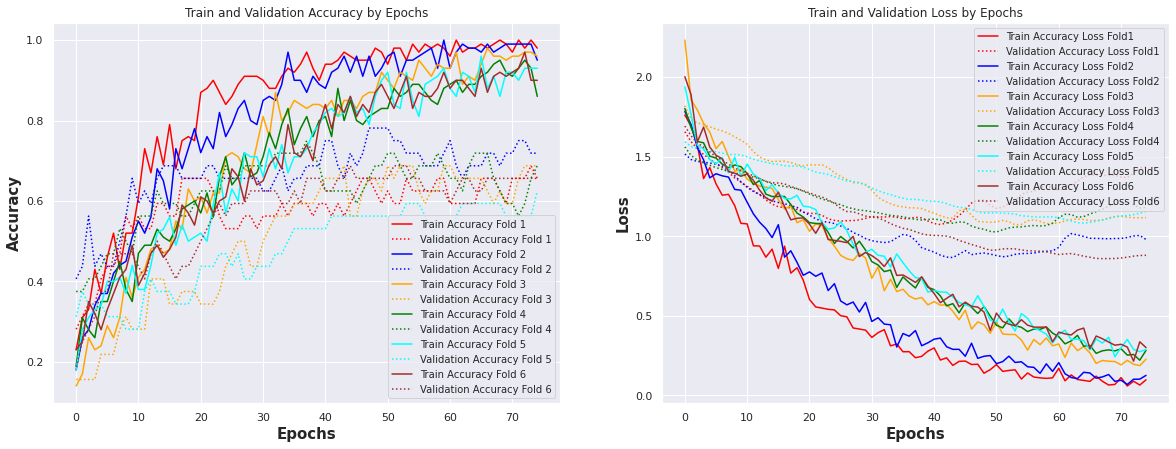

In [ ]:
plot_accuracy_loss(evolution_architecture,6)

Test different value of activation function

In [ ]:
parameters = ['relu', 'tanh', 'sigmoid']
evolution_activation = []
for activation in parameters:
  dnn_model = Sequential()
  dnn_model.add(Dense(128, activation = activation, input_dim=250))
  dnn_model.add(Dropout(0.5))
  dnn_model.add(Dense(32, activation = activation))
  dnn_model.add(Dense(5, activation='softmax'))
  dnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = dnn_model.fit(x_train, categorical_y_train, batch_size=32, epochs=75,validation_data=(x_validation, categorical_y_validation))
  evolution_activation.append(history)



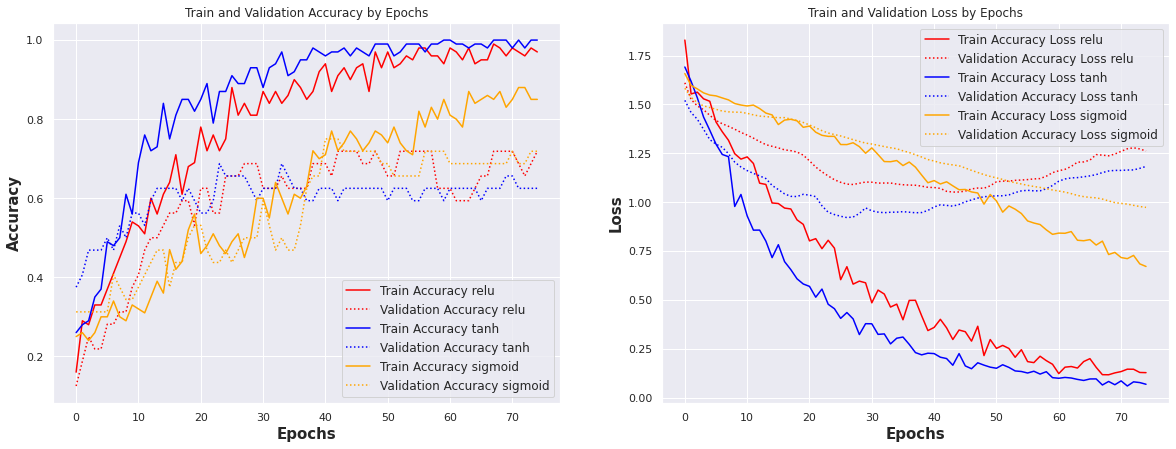

In [ ]:
plot_accuracy_loss(evolution_activation, len(parameters), parameters)

Test different value of dropout rate

In [ ]:
parameters = [0.001, 0.25, 0.35, 0.5]
evolution_dropout = []
for dropout in parameters:
  dnn_model = Sequential()
  dnn_model.add(Dense(128, activation = "sigmoid", input_dim=250))
  dnn_model.add(Dropout(dropout))
  dnn_model.add(Dense(32, activation = "sigmoid"))
  dnn_model.add(Dense(5, activation='softmax'))
  dnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = dnn_model.fit(x_train, categorical_y_train, batch_size=32, epochs=75,validation_data=(x_validation, categorical_y_validation))
  evolution_dropout.append(history)



Epoch 1/75
4/4 [==============================] - 1s 61ms/step - loss: 1.7324 - accuracy: 0.1485 - val_loss: 1.6824 - val_accuracy: 0.0625
Epoch 2/75
4/4 [==============================] - 0s 16ms/step - loss: 1.6466 - accuracy: 0.2537 - val_loss: 1.6144 - val_accuracy: 0.1875
Epoch 3/75
4/4 [==============================] - 0s 14ms/step - loss: 1.5766 - accuracy: 0.3164 - val_loss: 1.5723 - val_accuracy: 0.3438
Epoch 4/75
4/4 [==============================] - 0s 15ms/step - loss: 1.5332 - accuracy: 0.4067 - val_loss: 1.5381 - val_accuracy: 0.3750
Epoch 5/75
4/4 [==============================] - 0s 15ms/step - loss: 1.5181 - accuracy: 0.4064 - val_loss: 1.5168 - val_accuracy: 0.4375
Epoch 6/75
4/4 [==============================] - 0s 16ms/step - loss: 1.4949 - accuracy: 0.3728 - val_loss: 1.5029 - val_accuracy: 0.3438
Epoch 7/75
4/4 [==============================] - 0s 15ms/step - loss: 1.4827 - accuracy: 0.3657 - val_loss: 1.4853 - val_accuracy: 0.4375
Epoch 8/75
4/4 [===========

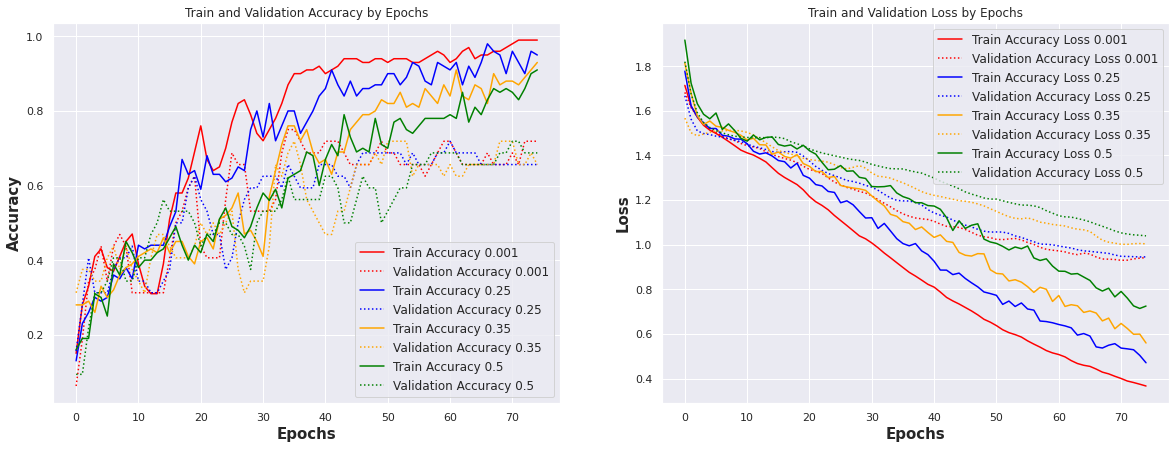

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

*K*-Fold cross-validation


In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

K = 7   # numbers of folds
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True) # creating the stratified k-fold cross validation


In [ ]:
validation_accuracy = []
validation_loss = []
k_fold_evolution = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(132),new_y_pooled):
  training_data = new_x_pooled[train_index]
  training_targets = targets[train_index]
  validation_data = new_x_pooled[val_index]
  validation_targets = targets[val_index]
  # create and compile new model
  dnn_model = Sequential()
  dnn_model.add(Dense(128, activation = "sigmoid", input_dim=250))
  dnn_model.add(Dropout(0.25))
  dnn_model.add(Dense(32, activation = "sigmoid"))
  dnn_model.add(Dense(5, activation='softmax'))
  dnn_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  print('------------------------------------------------------------------------')
  print('------------------------ history for fold {} ----------------------------'.format(fold_var))
  print('------------------------------------------------------------------------')
  history = dnn_model.fit(training_data, training_targets, batch_size=32, epochs=75,validation_data=(validation_data, validation_targets));

  # CREATE CALLBACKS
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
	# This saves the best model
  # Generate generalization metrics	
  results = dnn_model.evaluate(validation_data,validation_targets,verbose=0)
  results = dict(zip(dnn_model.metrics_names,results))
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  k_fold_evolution.append(history)
	
  backend.clear_session()
  fold_var += 1 # Increase fold number

    


Average scores for all folds:
> Accuracy: 65.07936545780727% (+- 6.0185171873719066%)
> Loss: 0.9946049451828003




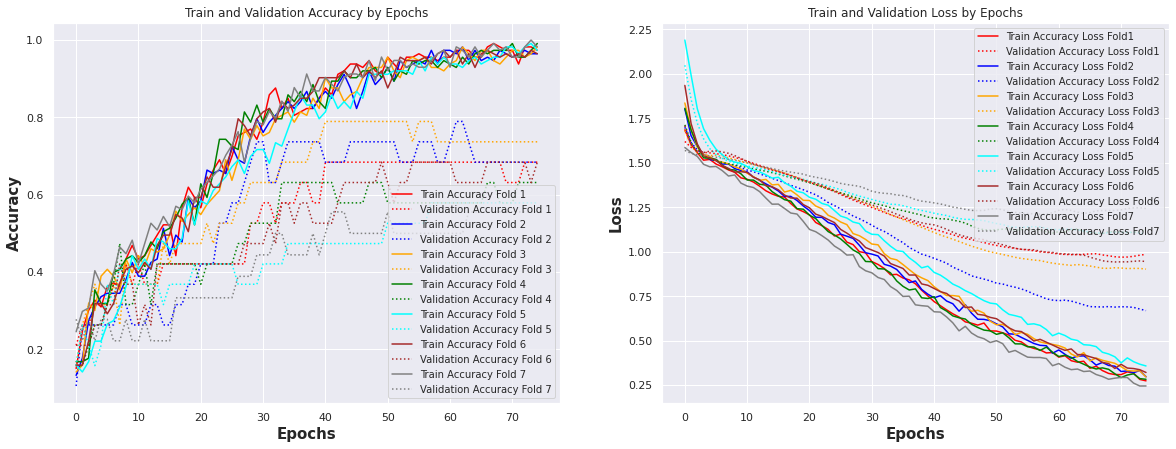

In [ ]:
# print useful result of stratified k-fold cross validation
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(validation_accuracy)*100}% (+- {np.std(validation_accuracy)*100}%)')
print(f'> Loss: {np.mean(validation_loss)}\n\n')
# plotting resuls of stratified k-fold cross validation
plot_accuracy_loss(k_fold_evolution,K)

### LSTM


In [ ]:
# creating the matrix of total words with gloVe values
index_words = {}
embeddings_index = {}

i = 0
fn = open(os.path.join('drive/MyDrive/ML_project/data_folder', 'glove.twitter.27B.25d.txt'))
word_arr = set()

for line in fn:
    values = line.split()
    word = values[0]
    word_arr.add(word)
    w_value = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = w_value
fn.close()
print('Library composed of {} word vectors.'.format(len(embeddings_index)))

for w in sorted(word_arr):
    index_words[w] = i
    i += 1



Library composed of 1193514 word vectors.


In [ ]:
# creating the matrix of our sentences populated with gloVe values
def index_sentences(txt, idx_word, maxlen):
  n_rows = txt.shape[0]
  sentence_indices = np.zeros((n_rows, maxlen))

  for row in range(n_rows):
      sentence_words = txt[row].lower().split()
      col_sentence = 0
      for w in sentence_words:
          sentence_indices[row, col_sentence] = idx_word[w]
          col_sentence += 1
  return sentence_indices
            

In [ ]:
feat_train = index_sentences(df_train['phrase'].values, index_words, 10)
feat_validation = index_sentences(df_validation['phrase'].values, index_words, 10)

features = np.concatenate((feat_train, feat_validation), axis = 0)
targets = np.concatenate((to_categorical(y_train), to_categorical(y_validation)), axis = 0)


In [ ]:
sequence_length = 10
embedding_dim = 25 
number_of_words = len(index_words.values())

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((len(embeddings_index), embedding_dim))

print(embedding_matrix.shape)

# then fill the matrix in order to be processed by the model
for word, i in index_words.items():
    try:
      embedding_matrix[i, :] = embeddings_index[word]
    except:
      continue


(1193514, 25)


Test different value of SpatialDropout

In [ ]:
parameters = [0.01, 0.1, 0.25, 0.5]
evolution_dropout = []

for dropout in parameters:
  lstm_model = Sequential()
  lstm_model.add(Embedding(number_of_words,
                      25,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  lstm_model.add(SpatialDropout1D(dropout))
  lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
  lstm_model.add(Bidirectional(LSTM(32)))
  lstm_model.add(Dropout(0.25))
  lstm_model.add(Dense(units=5, activation='softmax'))
  lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = lstm_model.fit(feat_train, categorical_y_train, batch_size=32, epochs=75, verbose=1, validation_data=(feat_validation ,categorical_y_validation))
  evolution_dropout.append(history)


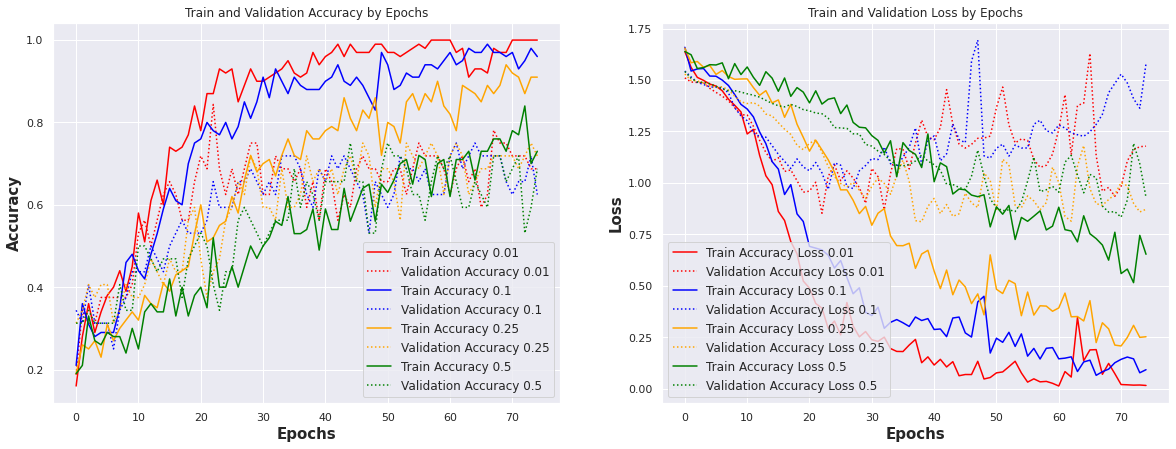

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

Test different value of Dropuot

In [ ]:
parameters = [0.1, 0.25, 0.5]
evolution_dropout = []

for dropout in parameters:
  lstm_model = Sequential()
  lstm_model.add(Embedding(number_of_words,
                      25,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  lstm_model.add(SpatialDropout1D(0.25))
  lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
  lstm_model.add(Bidirectional(LSTM(32)))
  lstm_model.add(Dropout(dropout))
  lstm_model.add(Dense(units=5, activation='softmax'))
  lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  history = lstm_model.fit(feat_train, categorical_y_train, batch_size=32, epochs=75, verbose=1, validation_data=(feat_validation ,categorical_y_validation))
  evolution_dropout.append(history)

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

*K*-Fold cross-validation


In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

K = 7   # numbers of folds
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True) # creating the stratified k-fold cross validation


In [ ]:
validation_accuracy = []
validation_loss = []
k_fold_evolution = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(132),new_y_pooled):
  training_data = features[train_index]
  training_targets = targets[train_index]
  validation_data = features[val_index]
  validation_targets = targets[val_index]
  # create and compile new model  
  lstm_model = Sequential()
  lstm_model.add(Embedding(number_of_words,
                      25,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  lstm_model.add(SpatialDropout1D(0.25))
  lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
  lstm_model.add(Bidirectional(LSTM(32)))
  lstm_model.add(Dropout(0.25))
  lstm_model.add(Dense(units=5, activation='softmax'))
  lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  print('------------------------------------------------------------------------')
  print('------------------------ history for fold {} ----------------------------'.format(fold_var))
  print('------------------------------------------------------------------------')
  history = lstm_model.fit(training_data, training_targets, batch_size=32, epochs=75,validation_data=(validation_data, validation_targets));

  # CREATE CALLBACKS
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]
	# This saves the best model
  # Generate generalization metrics	
  results = lstm_model.evaluate(validation_data,validation_targets,verbose=0)
  results = dict(zip(lstm_model.metrics_names,results))
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  k_fold_evolution.append(history)
	
  backend.clear_session()
  fold_var += 1 # Increase fold number


------------------------------------------------------------------------
------------------------ history for fold 1 ----------------------------
------------------------------------------------------------------------
Epoch 1/75
4/4 [==============================] - 10s 1s/step - loss: 1.6138 - accuracy: 0.2452 - val_loss: 1.5796 - val_accuracy: 0.3158
Epoch 2/75
4/4 [==============================] - 1s 314ms/step - loss: 1.5682 - accuracy: 0.2574 - val_loss: 1.5801 - val_accuracy: 0.3158
Epoch 3/75
4/4 [==============================] - 1s 311ms/step - loss: 1.5445 - accuracy: 0.3193 - val_loss: 1.5831 - val_accuracy: 0.2632
Epoch 4/75
4/4 [==============================] - 1s 312ms/step - loss: 1.5572 - accuracy: 0.2643 - val_loss: 1.5447 - val_accuracy: 0.2632
Epoch 5/75
4/4 [==============================] - 1s 315ms/step - loss: 1.4993 - accuracy: 0.2812 - val_loss: 1.5118 - val_accuracy: 0.3158
Epoch 6/75
4/4 [==============================] - 1s 322ms/step - loss: 1.4878 - ac

Average scores for all folds:
> Accuracy: 71.21971590178353% (+- 7.320556818684018%)
> Loss: 1.0251913581575667




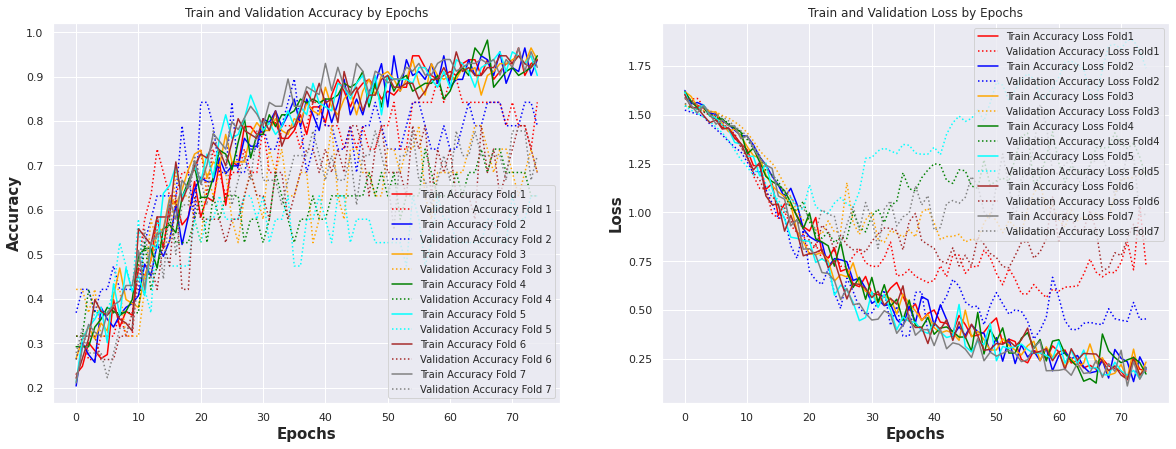

In [ ]:
# print useful result of stratified k-fold cross validation
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(validation_accuracy)*100}% (+- {np.std(validation_accuracy)*100}%)')
print(f'> Loss: {np.mean(validation_loss)}\n\n')
# plotting resuls of stratified k-fold cross validation
plot_accuracy_loss(k_fold_evolution,K)

# Evaluation

In [ ]:
##################################################
# Evaluate the model here
##################################################

# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.

# Send the submission for the challenge

In [ ]:

y_test_pred = None

# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))

x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy')).reshape(len(submission), -1)

submission["phrase"] = submission["phrase"].str.replace("\t", "")
# print(submission["phrase"]) 
string_submission = ["".join(x) for x in submission["phrase"]]



SVM Submission

In [ ]:
vect_svm = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 2)).fit(df_string_train)
x_train_vect_svm = vect_svm.transform(df_string_train)
x_test_vect_svm =  vect_svm.transform(string_submission)
best_svm = SVC(C = 10, gamma = 0.1, kernel = 'rbf').fit(x_train_vect_svm, new_y_pooled)
y_pred_svm = best_svm.predict(x_test_vect_svm)
y_pred_svm

array([4, 3, 3, 3, 2, 2, 3, 4, 4, 2, 1, 3, 3, 3, 1, 3, 3, 0, 3, 4, 0, 3,
       3, 3, 3, 3, 1, 0, 1, 3, 0, 1, 2, 2, 3, 3, 3, 4, 4, 0, 1, 0, 0, 1,
       2, 0, 3, 2, 2, 3, 3, 3, 1, 2, 3, 3])

Logistic Regression Submission

In [ ]:
vect_lr = TfidfVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 1)).fit(df_string_train)
x_train_vect_lr = vect_lr.transform(df_string_train)
x_test_vect_lr =  vect_lr.transform(string_submission)
best_lr = LogisticRegression(C = 10).fit(x_train_vect_lr, new_y_pooled)
y_pred_lr = best_lr.predict(x_test_vect_lr)
y_pred_lr

array([4, 3, 3, 3, 2, 2, 3, 4, 4, 2, 1, 3, 3, 3, 1, 3, 3, 0, 3, 4, 0, 3,
       3, 3, 3, 3, 1, 0, 1, 3, 0, 1, 2, 2, 3, 3, 3, 4, 4, 0, 1, 0, 0, 1,
       2, 0, 3, 2, 2, 3, 3, 3, 1, 2, 3, 3])

In [ ]:
##################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = None

# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))

x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy')).reshape(len(submission), -1)

if y_test_pred is not None:
     submission['class'] = y_test_pred
submission.to_csv('my_submission.csv', index=False)


In [ ]:

# create and compile new model  
lstm_model = Sequential()
lstm_model.add(Embedding(number_of_words,
                    25,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))
lstm_model.add(SpatialDropout1D(0.25))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(units=5, activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

history = lstm_model.fit(features, targets, batch_size=32, epochs=75);



In [ ]:

feat_submission = index_sentences(submission['phrase'].values, index_words, 10)

y_pred_lstm = lstm_model.predict(feat_submission)

a=np.argmax(y_pred_lstm, axis=1)
for i, v in enumerate(a):
  print("{}: {}".format(i,v))
  # print(np.argmax(y_pred_lstm, axis=1))
# print((y_pred_lstm))
# numpy.amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>)

# print(df_train)